In [90]:
import os
import time

import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
print(f'tf.__version__: {tf.__version__}')
import sklearn
print(f'sklearn.__version__: {sklearn.__version__}')
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

tf.__version__: 2.3.0
sklearn.__version__: 0.21.2


In [2]:
(X_train_full, y_train_full), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

class_names = np.array([
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])

In [3]:
HEIGHT, WIDTH = X_train_full[0].shape

MIN, MAX = X_train_full.min(), X_train_full.max()

Train using Gradient Descent -> scale features (otherwise some weights will update much faster than others)

In [4]:
VAL_SIZE = 5_000

X_valid, X_train, X_test = X_train_full[:VAL_SIZE] / MAX, X_train_full[VAL_SIZE:] / MAX, X_test / MAX
y_valid, y_train = y_train_full[:VAL_SIZE], y_train_full[VAL_SIZE:]

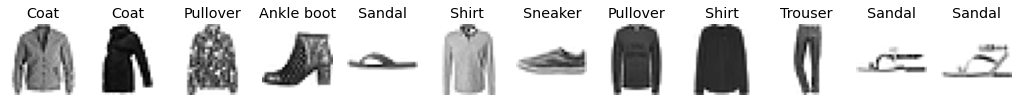

In [5]:
img_count = 12
idx = np.random.randint(0, X_train.shape[0], size=img_count)

plt.figure(figsize=(18, 3))
for i, (class_id, img) in enumerate(zip(y_train[idx], X_train[idx])):
    plt.subplot(1, img_count, i + 1)
    plt.title(class_names[class_id])
    plt.imshow(MAX - img, cmap='gray')
    plt.axis('off')

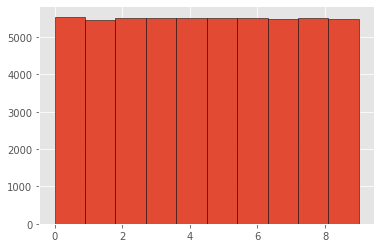

In [6]:
plt.hist(y_train, edgecolor='k');

# Classification with Sequential API

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[HEIGHT, WIDTH]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"), # tf.keras.activations.relu
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(class_names.size, activation="softmax")
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


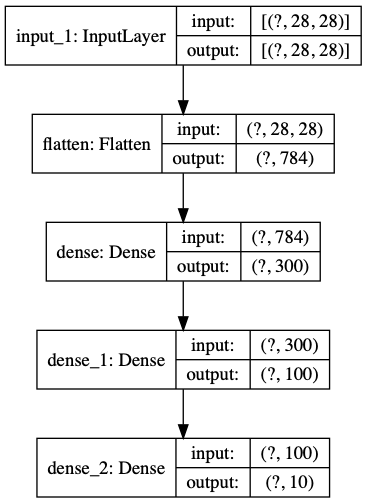

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.layers

In [11]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [12]:
model.get_layer('dense') is hidden1

True

(784, 300) (300,)


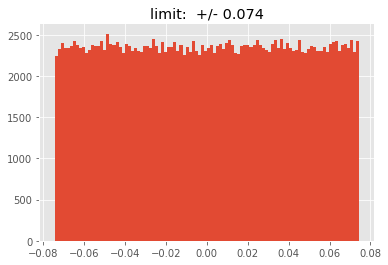

In [13]:
weights, biases = hidden1.get_weights()

print(weights.shape, biases.shape)

plt.title(f'limit:  +/- {(6 / sum(weights.shape)) ** 0.5:.3f}')
plt.hist(weights.reshape(-1), bins=100);

default initializers:
* `kernel_initializer`: [The Glorot uniform initializer, also called Xavier uniform initializer](http://proceedings.mlr.press/v9/glorot10a.html) (`tf.keras.initializers.GlorotUniform`)
* `bias_initializer`: Zeros (`tf.keras.initializers.Zeros`)

In [14]:
model.compile(
    loss="sparse_categorical_crossentropy", # tf.keras.losses.SparseCategoricalCrossentropy
    optimizer="sgd", # tf.keras.optimizers.SGD
    metrics=["accuracy"] # tf.keras.metrics.SparseCategoricalAccuracy
)

* `y` represented as sparse vector (for each instance, there is just a target class index) => `SparseCategoricalCrossentropy`
* `y` represented as one-hot vector => `CategoricalCrossentropy`

`.fit` method params:
* `class_weight`: parameter for working with skewed dataset (when some classes being overrepresented and others underrepresented); in this case, it would be useful to give a larger loss weight to underrepresented classes and a lower loss weight to overrepresented classes
* `sample_weight`: parameter for create per-instance loss weight (if some instances were labeled by experts while others were labeled using a crowdsourcing platform)

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=64)

Epoch 1/30
860/860 [==============================] - 1s 2ms/step - loss: 0.8437 - accuracy: 0.7333 - val_loss: 0.5739 - val_accuracy: 0.8118
Epoch 2/30
860/860 [==============================] - 1s 1ms/step - loss: 0.5414 - accuracy: 0.8165 - val_loss: 0.5046 - val_accuracy: 0.8286
Epoch 3/30
860/860 [==============================] - 1s 1ms/step - loss: 0.4862 - accuracy: 0.8323 - val_loss: 0.4485 - val_accuracy: 0.8526
Epoch 4/30
860/860 [==============================] - 1s 1ms/step - loss: 0.4562 - accuracy: 0.8417 - val_loss: 0.4577 - val_accuracy: 0.8426
Epoch 5/30
860/860 [==============================] - 1s 2ms/step - loss: 0.4368 - accuracy: 0.8486 - val_loss: 0.4486 - val_accuracy: 0.8474
Epoch 6/30
860/860 [==============================] - 1s 1ms/step - loss: 0.4203 - accuracy: 0.8541 - val_loss: 0.4289 - val_accuracy: 0.8500
Epoch 7/30
860/860 [==============================] - 1s 1ms/step - loss: 0.4078 - accuracy: 0.8582 - val_loss: 0.3977 - val_accuracy: 0.8672
Epoch 

In [16]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 860}

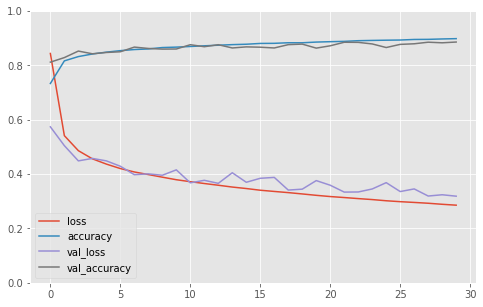

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1);

In [18]:
model.evaluate(X_test, y_test, batch_size=256)

40/40 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8722


[0.3537355959415436, 0.8722000122070312]

In [19]:
predicted_probas = model.predict(X_test)
predicted_ids = predicted_probas.argmax(axis=1)

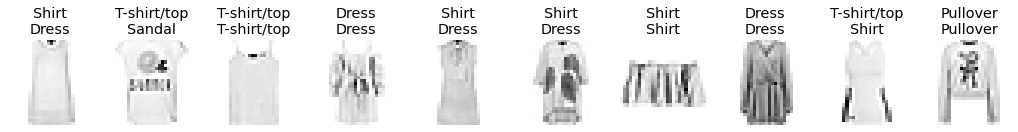

In [20]:
top_k = 10

entropy = scipy.stats.entropy(predicted_probas, axis=1)
idx = scipy.stats.entropy(predicted_probas, axis=1).argsort()[::-1][:top_k]

plt.figure(figsize=(18, 3))
for i, (class_id, pred_class_id, img) in enumerate(zip(y_test[idx], predicted_ids[idx], X_test[idx])):
    plt.subplot(1, top_k, i + 1)
    plt.title(f'{class_names[class_id]}\n{class_names[pred_class_id]}')
    plt.imshow(MAX - img, cmap='gray')
    plt.axis('off')

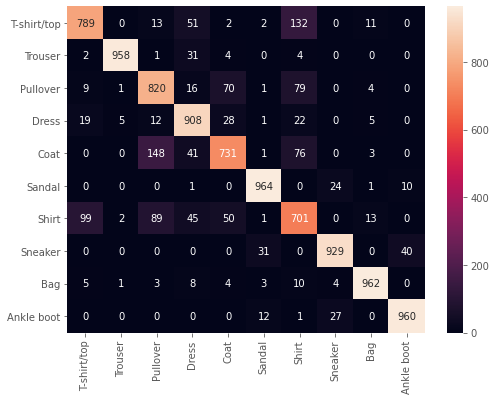

In [21]:
plt.figure(figsize=(8,6))

sns.heatmap(
    pd.DataFrame(confusion_matrix(y_test, predicted_ids), index=class_names, columns=class_names),
    annot=True, fmt='d'
);

# Regression with Sequential API

In [22]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=False)

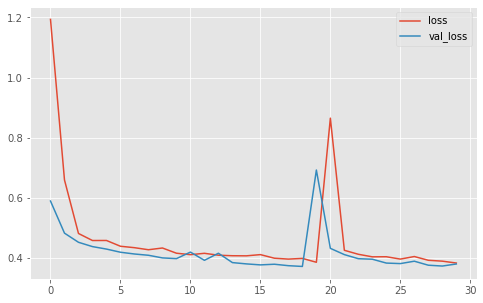

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5));

In [25]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 554us/step - loss: 0.3886


0.38860028982162476

# Functional API: [Wide & Deep](https://arxiv.org/pdf/1606.07792.pdf)

![architecture](img/wide_and_deep.png)

Wide&Deep architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path). The short path also can be used to provide handcrafted features directly to the  network

In [26]:
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([input_, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_], outputs=[output])

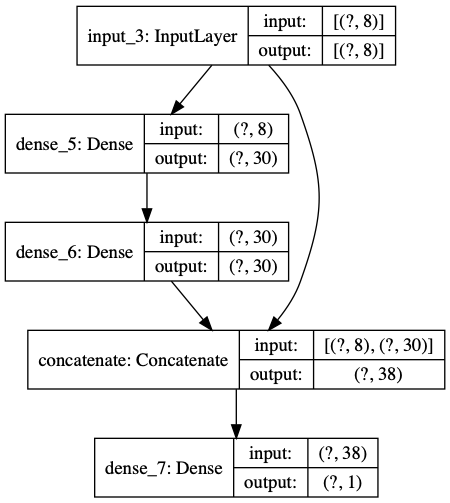

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3))
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=False)

In [29]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 493us/step - loss: 0.3286


0.328607976436615

In [30]:
input_A = tf.keras.layers.Input(shape=[5], name="wide_input")
input_B = tf.keras.layers.Input(shape=[6], name="deep_input")
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([input_A, hidden2])
output = tf.keras.layers.Dense(1, name="output")(concat)
model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])

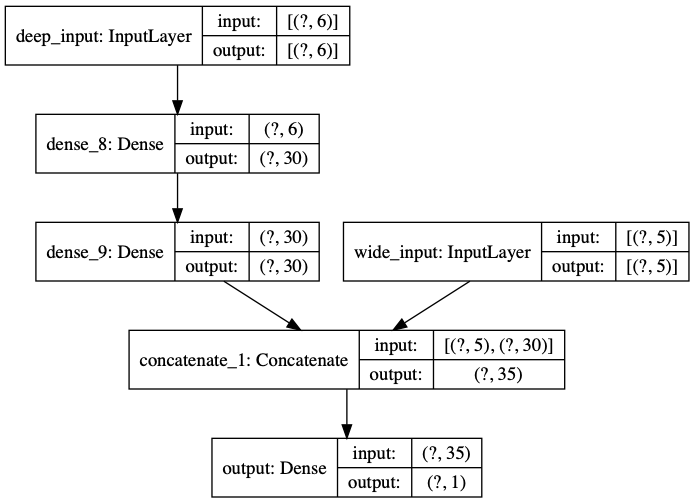

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
X_train.shape

(11610, 8)

In [33]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=5e-3))

# features (0, 1, 2, 3, 4) -> wide_input
# features (2, 3, 4, 5, 6, 7) -> deep_input
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

history = model.fit(
    (X_train_A, X_train_B), y_train, epochs=30, verbose=False,
    validation_data=((X_valid_A, X_valid_B), y_valid)
)

In [34]:
model.evaluate((X_test_A, X_test_B), y_test)

162/162 [==============================] - 0s 565us/step - loss: 0.3668


0.36680302023887634

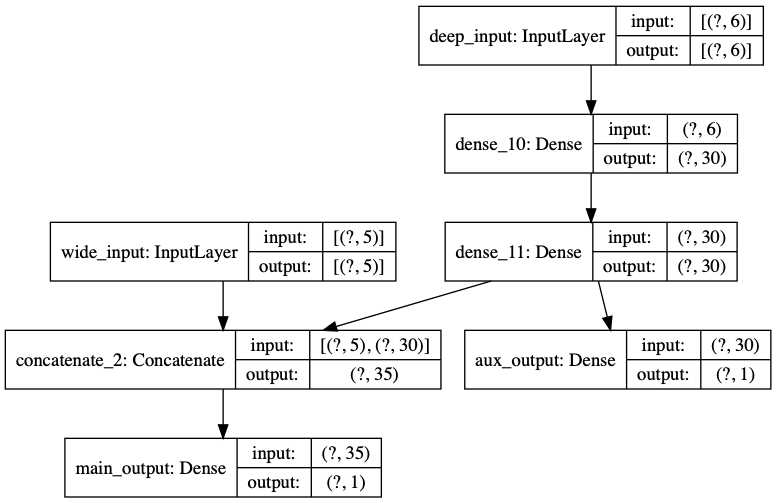

In [35]:
input_A = tf.keras.layers.Input(shape=[5], name="wide_input")
input_B = tf.keras.layers.Input(shape=[6], name="deep_input")
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([input_A, hidden2])
output = tf.keras.layers.Dense(1, name="main_output")(concat)
aux_output = tf.keras.layers.Dense(1, name="aux_output")(hidden2)
model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss={"main_output": "mse", "aux_output": "mse"}, 
    loss_weights={"main_output": 0.9, "aux_output": 0.1},
    optimizer="sgd"
)

tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=30,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9768 - main_output_loss: 0.7963 - aux_output_loss: 2.6016 - val_loss: 0.6197 - val_main_output_loss: 0.5486 - val_aux_output_loss: 1.2593
Epoch 2/30
363/363 [==============================] - 0s 868us/step - loss: 0.5939 - main_output_loss: 0.5240 - aux_output_loss: 1.2227 - val_loss: 0.5451 - val_main_output_loss: 0.4858 - val_aux_output_loss: 1.0787
Epoch 3/30
363/363 [==============================] - 0s 783us/step - loss: 0.5495 - main_output_loss: 0.4956 - aux_output_loss: 1.0346 - val_loss: 0.5138 - val_main_output_loss: 0.4672 - val_aux_output_loss: 0.9334
Epoch 4/30
363/363 [==============================] - 0s 802us/step - loss: 0.5186 - main_output_loss: 0.4756 - aux_output_loss: 0.9062 - val_loss: 0.4853 - val_main_output_loss: 0.4473 - val_aux_output_loss: 0.8271
Epoch 5/30
363/363 [==============================] - 0s 791us/step - loss: 0.5013 - main_output_loss: 0.4663 - aux_output_loss: 0.8162 - 

In [37]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)

162/162 [==============================] - 0s 481us/step - loss: 0.3543 - main_output_loss: 0.3398 - aux_output_loss: 0.4843


# Subclassing API

useful for Dynamic Models (with loops, varying shapes, conditional branching, and other dynamic behaviors)

In [38]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [39]:
model = WideAndDeepModel()
model.compile(
    loss=["mse", "mse"], 
    loss_weights=[0.9, 0.1],
    optimizer="sgd"
)
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=30, verbose=False,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

In [40]:
model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)

162/162 [==============================] - 0s 472us/step - loss: 0.4735 - output_1_loss: 0.4710 - output_2_loss: 0.4954


[0.47345709800720215, 0.47101733088493347, 0.4954167306423187]

model's architecture is hidden within `call()` method => Keras cannot easily inspect it; it cannot save or clone it

In [41]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  210       
_________________________________________________________________
dense_13 (Dense)             multiple                  930       
_________________________________________________________________
dense_14 (Dense)             multiple                  36        
_________________________________________________________________
dense_15 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


# Save and Restore model

## save model weights, hyperparameters, optimizer state, etc using HDF5

In [42]:
input_A = tf.keras.layers.Input(shape=[5], name="wide_input")
input_B = tf.keras.layers.Input(shape=[6], name="deep_input")
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([input_A, hidden2])
output = tf.keras.layers.Dense(1, name="main_output")(concat)
aux_output = tf.keras.layers.Dense(1, name="aux_output")(hidden2)
model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss={"main_output": "mse", "aux_output": "mse"}, 
    loss_weights={"main_output": 0.9, "aux_output": 0.1},
    optimizer="sgd"
)

model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=30, verbose=False,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

In [43]:
model.save("wide_and_deep.h5")

In [44]:
loaded_model = tf.keras.models.load_model("wide_and_deep.h5")

In [45]:
loaded_model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)

162/162 [==============================] - 0s 522us/step - loss: 0.3543 - main_output_loss: 0.3427 - aux_output_loss: 0.4587


[0.3543124794960022, 0.34271034598350525, 0.45873138308525085]

## save model weights only

In [46]:
model = WideAndDeepModel()
model.compile(
    loss=["mse", "mse"], 
    loss_weights=[0.9, 0.1],
    optimizer="sgd"
)
model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=30, verbose=False,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

In [47]:
model.save_weights("wide_and_deep.ckpt")

In [48]:
new_model = WideAndDeepModel()

new_model.compile(
    loss=["mse", "mse"], 
    loss_weights=[0.9, 0.1],
    optimizer="sgd"
)

new_model.load_weights("wide_and_deep.ckpt")

new_model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.3543 - output_1_loss: 0.3391 - output_2_loss: 0.4912


[0.35429298877716064, 0.3390807509422302, 0.49120160937309265]

# Callbacks

## resave model after each epoch

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5")

model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb], verbose=False
)

## resave model only if the validation set performance increased 

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=False, callbacks=[checkpoint_cb])
model = tf.keras.models.load_model("model.h5") # roll back to best model

## interrupt training when performance no progress on the validation set

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 0s 786us/step - loss: 0.8103 - val_loss: 0.5798
Epoch 2/100
363/363 [==============================] - 0s 594us/step - loss: 0.5248 - val_loss: 0.4787
Epoch 3/100
363/363 [==============================] - 0s 608us/step - loss: 0.4582 - val_loss: 0.4363
Epoch 4/100
363/363 [==============================] - 0s 614us/step - loss: 0.4296 - val_loss: 0.4042
Epoch 5/100
363/363 [==============================] - 0s 598us/step - loss: 0.4198 - val_loss: 0.4025
Epoch 6/100
363/363 [==============================] - 0s 595us/step - loss: 0.4040 - val_loss: 0.3809
Epoch 7/100
363/363 [==============================] - 0s 600us/step - loss: 0.3952 - val_loss: 0.3743
Epoch 8/100
363/363 [==============================] - 0s 603us/step - loss: 0.3862 - val_loss: 0.3718
Epoch 9/100
363/363 [==============================] - 0s 607us/step - loss: 0.3783 - val_loss: 0.3693
Epoch 10/100
363/363 [==============================] - 0s 613us/step - l

## custom callbacks

In [52]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [53]:
model.compile(loss="mean_squared_error", optimizer="sgd")

metric_cb = PrintValTrainRatioCallback()
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[metric_cb])
model = tf.keras.models.load_model("model.h5") # roll back to best model

Epoch 1/10
329/363 [==========================>...] - ETA: 0s - loss: 0.3230
val/train: 1.05
363/363 [==============================] - 0s 790us/step - loss: 0.3224 - val_loss: 0.3379
Epoch 2/10
332/363 [==========================>...] - ETA: 0s - loss: 0.3168
val/train: 1.02
363/363 [==============================] - 0s 607us/step - loss: 0.3198 - val_loss: 0.3248
Epoch 3/10
325/363 [=========================>....] - ETA: 0s - loss: 0.3184
val/train: 1.02
363/363 [==============================] - 0s 616us/step - loss: 0.3168 - val_loss: 0.3237
Epoch 4/10
344/363 [===========================>..] - ETA: 0s - loss: 0.3161
val/train: 1.00
363/363 [==============================] - 0s 592us/step - loss: 0.3172 - val_loss: 0.3178
Epoch 5/10
343/363 [===========================>..] - ETA: 0s - loss: 0.3107
val/train: 1.13
363/363 [==============================] - 0s 594us/step - loss: 0.3123 - val_loss: 0.3532
Epoch 6/10
338/363 [==========================>...] - ETA: 0s - loss: 0.3152
val

# TensorBoard

In [54]:
root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train, epochs=150, batch_size=15, verbose=False,
    validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb, early_stopping_cb]
)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


```bash
$ tensorboard --logdir=./logs --port=6006
```

In [56]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

# Hyperparameters Optimization

In [57]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=learning_rate))
    return model

In [58]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(X_train, y_train, epochs=100, verbose=False,
              validation_data=(X_valid, y_valid),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 383us/step - loss: 0.3628


In [59]:
mse_test

-0.362821489572525

(for scikit-learn higher is better)

In [60]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": scipy.stats.reciprocal(3e-4, 3e-2),
}

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(
    X_train, y_train, epochs=100,  verbose=False,
    validation_data=(X_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


121/121 [==============================] - 0s 373us/step - loss: 0.4291
[CV]  learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99, total=  12.7s
[CV] learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s


121/121 [==============================] - 0s 378us/step - loss: 0.4341
[CV]  learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99, total=  12.9s
[CV] learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99 ...
121/121 [==============================] - 0s 381us/step - loss: 0.4375
[CV]  learning_rate=0.0007684503789826062, n_hidden=1, n_neurons=99, total=  12.8s
[CV] learning_rate=0.011630621401864496, n_hidden=3, n_neurons=93 ....
121/121 [==============================] - 0s 408us/step - loss: 0.3078
[CV]  learning_rate=0.011630621401864496, n_hidden=3, n_neurons=93, total=  10.6s
[CV] learning_rate=0.011630621401864496, n_hidden=3, n_neurons=93 ....
121/121 [==============================] - 0s 414us/step - loss: 0.3234
[CV]  learning_rate=0.011630621401864496, n_hidden=3, n_neurons=93, total=  13.6s
[CV] learning_rate=0.011630621401864496, n_hidden=3, n_neurons=93 ....
121/121 [==============================] - 0s 426us/step - loss: 0.3235
[CV]  learning_rate=0.0116

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.8min finished
/Users/g.gospodinov/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb9222ca990>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb9222ca9d0>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_trai

In [61]:
rnd_search_cv.best_params_

{'learning_rate': 0.0042175593843033045, 'n_hidden': 2, 'n_neurons': 78}

In [62]:
rnd_search_cv.best_score_

-0.31630144516626996

Today there are techniques for discovering neural network structure:
* [Evolutionaly AutoML (Google)](https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html)
* [NeuroEvolution (Uber)](https://eng.uber.com/deep-neuroevolution/) 

But intuition about reasonable values for each hyperparameter allows you to build a quick prototype and restrict the search space.

Good sources for getting such intuition:
* [A disciplined approach to neural network hyper-parameters](https://arxiv.org/abs/1803.09820)
* [A Recipe for Training Neural Networks](http://karpathy.github.io/2019/04/25/recipe/)

### Number of hidden layers

Real-world data is often structured in a hierarchical way, and deep neural networks automatically take advantage of this fact: lower hidden layers model low-level structures (e.g., line segments of various shapes and orientations), intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g., squares, circles), and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g., faces) (image from [paper](https://dl.acm.org/doi/10.1145/1553374.1553453)):

![patterns](img/conv_net_patterns.png)

For many problems you can start with just one or two hidden layers and the neural network will work just fine. For more complex problems, you can ramp up the number of hidden layers until you start overfitting the training set. Very complex tasks, such as large image classification or speech recognition, typically require networks with dozens of layers and a huge amount of training data. You will rarely have to train such networks from scratch: it is much more common to reuse parts of a pretrained state-of-the-art network that performs a similar task (Transfer Learning).

### Number of neurons per layer

It used to be common to size hidden layers to form a pyramid, with fewer and fewer neurons at each layer: many low-level features can coalesce into far fewer high-level features. Nevertheless, this practice has been largely abandoned because it seems that using the same number of neurons in all hidden layers performs just as well in most cases, or even better; plus, there is only one hyperparameter to tune, instead of one per layer.

### Learning Rate

The learning rate is arguably the most important hyperparameter. In general, the optimal learning rate is about half of the learning rate above which the training algorithm diverges. One way to find a good learning rate is to train the model for a few hundred iterations, starting with a very low learning rate (e.g., $10^{-5}$) and gradually increasing it up to a very large value (e.g., $10$). This is done by multiplying the learning rate by a constant factor at each iteration (e.g., by $\exp(\frac{\log 10^6}{500})$ to go from $10^{-5}$ to $10$ in $500$ iterations). If you plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate.

### Batch Size

The optimal learning rate depends on other hyperparameters, especially on the batch size. Hence, if you modify any hyperparameter, make sure to update the learning rate as well. Small batch size lead to low GPU utilization. Large batch sizes often lead to training instabilities, especially at the beginning of training, and the resulting model may not generalize as well as a model trained with a small batch size (learning rate warm-up can help in this mode)

### Activation function

ReLU activation function will be a good default for all hidden layers

### Number of iterations
Use EarlyStopping

# Mnist Classification Task

In [72]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train_full, X_test = X_train_full / 255.0, X_test / 255.0

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

HEIGHT, WIDTH = X_train[0].shape

In [113]:
min_lr = 1e-3
max_lr = 1
step_count = 50
factor = np.exp(np.log(max_lr  / min_lr) / step_count)
lr = min_lr

histories = []
rates = []

for i in tqdm(range(step_count)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(HEIGHT, WIDTH)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.SGD(lr=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=tf.keras.metrics.SparseCategoricalAccuracy()
    )
    
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=1, verbose=False
    )
    
    histories.append(history)
    rates.append(lr)
    lr *= factor

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


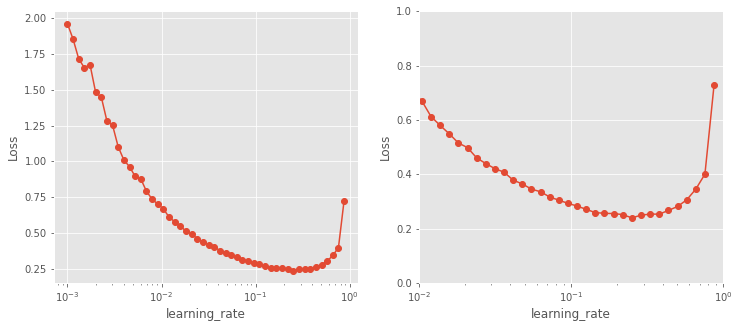

In [120]:
losses = [history.history['loss'][0] for history in histories]

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(rates, losses, 'o-')
plt.xscale('log')
plt.xlabel('learning_rate')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(rates, losses, 'o-')
plt.xscale('log')
plt.xlabel('learning_rate')
plt.ylabel('Loss')
plt.xlim([1e-2, 1])
plt.ylim([0, 1])
plt.show()

In [118]:
best_lr = 2e-1

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(HEIGHT, WIDTH)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=best_lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
    
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=150,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/150
1688/1688 [==============================] - 2s 977us/step - loss: 0.2503 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.1401 - val_sparse_categorical_accuracy: 0.9543
Epoch 2/150
1688/1688 [==============================] - 1s 867us/step - loss: 0.1064 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.2677 - val_sparse_categorical_accuracy: 0.9147
Epoch 3/150
1688/1688 [==============================] - 2s 895us/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.0769 - val_sparse_categorical_accuracy: 0.9782
Epoch 4/150
1688/1688 [==============================] - 1s 873us/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0771 - val_sparse_categorical_accuracy: 0.9755
Epoch 5/150
1688/1688 [==============================] - 1s 875us/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9805
Epoch 6/150
1688/1688 [==============================] - 2s 891us/step - lo

In [119]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 793us/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9798


[0.06480588018894196, 0.9797999858856201]